# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC

import xgboost

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder

from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OutputCodeClassifier

In [2]:
# figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_theme(style="whitegrid")
sns.set_palette(palette="Paired")

# set seed
np.random.seed(42)

# Load data

In [3]:
X_train = pd.read_csv("../../data/processed/train_data_cleaned.csv")
y_train = pd.read_csv("../../data/processed/train_labels.csv")

In [4]:
X_train = X_train.iloc[:100000] # max 260601
y_train = y_train.iloc[:100000] # max 260601

In [5]:
sample_size = y_train.shape[0]

# Import previously used functions

In [6]:
def compare_models_cv_acc_mcc(cv_results_list, model_names, n_samples, ylim, figsize, title) -> None:
    """
    Plot stacked bar charts to compare cross-validation results of different models. The plot will contain two subplots, one for accuracy and one for MCC. The plot will also contain horizontal guidelines for random guessing and the mean accuracy and MCC.

    :param cv_results_list: A list of dicts of float arrays of shape (n_splits,) that contain the cross-validation results of each model. Follows sklearn.model_selection.cross_validate() output format. See https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate for more details. Must contain the following keys: "test_accuracy", "test_matthews_corrcoef" in each dict list element. The length and order of the list must be equal to the length of model_names.
    :type cv_results_list: list
    :param model_names: A list of strings that represent the names of each model. The length and order of the list must be equal to the length of cv_results_list.
    :type model_names: list
    :param n_samples: The number of samples used in the cross-validation.
    :type n_samples: int
    :param ylim: The y-axis limits of the plot. Must be a tuple of two floats. The first float is the lower limit and the second float is the upper limit. The lower limit must be greater than or equal to 0. The upper limit must be less than or equal to 1.
    :type ylim: tuple
    :param figsize: The width and height of the plot in inches. Must be a tuple of two floats. The first float is the width and the second float is the height.
    :type figsize: tuple

    :return: None
    :rtype: None
    """

    # Check
    try:
        assert len(cv_results_list) == len(model_names)
    except AssertionError:
        print("cv_results_list and model_names must have the same length.")
        return

    # Calculate nrows and ncols
    if len(model_names) > 3:
        nrows = 2
        ncols = int(np.ceil(len(model_names) / 2))
    else:
        nrows = 1
        ncols = len(model_names)

    # Create a figure
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    # Set palette
    palette = {
        "ACCURACY": sns.color_palette("Paired")[0],
        "MATTHEWS_CORRCOEF": sns.color_palette("Paired")[2]
    }

    # Plot each model
    for i, (cv_results, model_name) in enumerate(zip(cv_results_list, model_names)):
        # Create a dataframe
        df = pd.DataFrame(cv_results).reset_index(names='k-fold')
        df_melt = df[['k-fold', 'test_accuracy', 'test_matthews_corrcoef']].melt(id_vars=['k-fold'], var_name='Metric', value_name='Score')
        df_melt['Metric'] = df_melt['Metric'].str.replace('test_', '')
        df_melt['Metric'] = df_melt['Metric'].str.upper()
        df_melt['k-fold'] = df_melt['k-fold'] + 1

        # Calculate mean and std
        agg = df_melt.groupby('Metric')['Score'].agg(['mean', 'std'])
        cv_mcc_mean = agg.loc["MATTHEWS_CORRCOEF"].at["mean"]
        cv_mcc_std = agg.loc["MATTHEWS_CORRCOEF"].at["std"]
        cv_acc_mean = agg.loc["ACCURACY"].at["mean"]
        cv_acc_std = agg.loc["ACCURACY"].at["std"]
        # Plot
        sns.barplot(x='k-fold', y='Score', hue='Metric', data=df_melt, ax=axes[i], dodge=False, errorbar=None, palette=palette)
        axes[i].set_title(f"Test Scoring {model_name}" + "\n" +
                          f"Mean MCC: {cv_mcc_mean:.3f} +/- {cv_mcc_std:.3f}, Mean ACC: {cv_acc_mean:.3f} +/- {cv_acc_std:.3f}")
        axes[i].legend().set_visible(False)
        # Add guidelines
        xmin, xmax = axes[i].get_xlim()
        axes[i].hlines(y=0.5, xmin=xmin, xmax=xmax, linestyles="dotted", colors='r', label="0.5")
        axes[i].hlines(y=cv_mcc_mean, xmin=xmin, xmax=xmax, linestyles="dashed", colors=sns.color_palette("Paired")[3], label="Mean MCC")
        axes[i].hlines(y=cv_acc_mean, xmin=xmin, xmax=xmax, linestyles="dashed", colors=sns.color_palette("Paired")[1], label="Mean ACC")
        # Set y-axis limits
        plt.setp(axes[i], ylim=ylim)

    # Set legend
    handles, labels = axes[0].get_legend_handles_labels()
    order = [0, 2, 3, 1, 4]
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
    if title is None:
        title = f"Cross Validation Results ({n_samples} samples)"
    plt.suptitle(title, fontweight='bold')

    # Show plot
    plt.tight_layout()
    plt.show()

# Multiclass scenario
Option 1: **Classifiers supporting multiclass classification**, like Random Forest, XGBoost, CatBoost, etc. (already tested in the [notebooks of week 4](../week04)
Option 2: Ensemble of **binary classifiers with meta-strategies** like One-vs-all, One-vs-one, Output coding, etc.

**Explanation:** Most classifiers are limited to distinguishing between a handful of classes well (they will start to struggle when the number of classes becomes very high). Therefore, if you have a lot of classes, instead of training a single classifier for more than 2 classes, you can train multiple binary classifiers - which is easier for each classifier to learn. Then combine each of the classifiers’ binary outputs to generate multi-class outputs. For this purpose there are different kind of meta-strategies:

1. One-vs-all / One-vs-rest (OvA / OvR): One classifier per class (other classes forming the 2nd class)
2. One-vs-one (OvO): One classifier per pair of classes
3. Output coding: Encode class labels as binary number, one classifier per bit

Possible forward-looking downsides:
- A possible downside of this approach is that it requires one model to be created for each class. For example, three classes requires three models. This could be an issue for our large datasets (e.g. millions of rows) or slow models (e.g. neural networks) used.
- Another potential downside of this approach is that it requires the base models to be skillful. This is not a problem for some models, such as decision trees, but can be a problem for other models, such as logistic regression or neural networks. Which did not perform well in our case at all, as seen previously.



In [7]:
# Base Model
from src.modelling import hyperparameter_optimization
base_model, base_cv_results = hyperparameter_optimization(model="XGBoost", train_data=X_train, train_labels=y_train, scoring=["accuracy", "matthews_corrcoef"])

Fitting XGBoost ...

CV Training ACC: 0.9971 +/- 0.0002 
CV Test ACC: 0.722 +/- 0.0021

CV Training MCC: 0.9949 +/- 0.0004 
CV Test MCC: 0.4788 +/- 0.0043



## 1. One-vs-all / One-vs-rest (OvA / OvR)
Reference: "Machine Learning: A Probabilistic Perspective" 2012 by Kevin P. Murphy, Chapter 8.3.1, p. 503

This approach is commonly used for algorithms that naturally predict numerical class membership probability or score, such as:
- **Logistic Regression** and
- **Perceptron**.

Therefor these are tested using the implementation in scikit-learn. For comparison also the implementation of **XGBoost** and **Linear SVC** is tested, which is not a probabilistic model.

### Logistic Regression

In [8]:
%%time
# define model
lr = LogisticRegression(multi_class='ovr',
                        random_state=42,
                        max_iter=1000,)
# cross validation
scores_lr_ovr = cross_validate(lr, X_train, y_train['damage_grade'], cv=5, scoring=['accuracy', 'f1_macro', 'matthews_corrcoef'], n_jobs=-1)

# print results
print(f"Accuracy: {scores_lr_ovr['test_accuracy'].mean():.3f} +/- {scores_lr_ovr['test_accuracy'].std():.3f}")
print(f"F1 Macro: {scores_lr_ovr['test_f1_macro'].mean():.3f} +/- {scores_lr_ovr['test_f1_macro'].std():.3f}")
print(f"MCC: {scores_lr_ovr['test_matthews_corrcoef'].mean():.3f} +/- {scores_lr_ovr['test_matthews_corrcoef'].std():.3f}")
print('-'*20)
print(f"With Runtime: {scores_lr_ovr['fit_time'].mean():.3f} +/- {scores_lr_ovr['fit_time'].std():.3f}")
print('='*20)

Accuracy: 0.568 +/- 0.000
F1 Macro: 0.241 +/- 0.000
MCC: 0.000 +/- 0.000
--------------------
With Runtime: 0.627 +/- 0.019
CPU times: total: 46.9 ms
Wall time: 2.69 s


### Perceptron

In [9]:
%%time
# define model
mlp = MLPClassifier(max_iter=200,
                    random_state=42)

# cross validation
scores_mlp_ovr = cross_validate(mlp, X_train, y_train['damage_grade'], cv=5, scoring=['accuracy', 'f1_macro', 'matthews_corrcoef'], n_jobs=-1)

# print results
print(f"Accuracy: {scores_mlp_ovr['test_accuracy'].mean():.3f} +/- {scores_mlp_ovr['test_accuracy'].std():.3f}")
print(f"F1 Macro: {scores_mlp_ovr['test_f1_macro'].mean():.3f} +/- {scores_mlp_ovr['test_f1_macro'].std():.3f}")
print(f"MCC: {scores_mlp_ovr['test_matthews_corrcoef'].mean():.3f} +/- {scores_mlp_ovr['test_matthews_corrcoef'].std():.3f}")
print('-'*20)
print(f"With Runtime: {scores_mlp_ovr['fit_time'].mean():.3f} +/- {scores_mlp_ovr['fit_time'].std():.3f}")
print('='*20)

Accuracy: 0.476 +/- 0.112
F1 Macro: 0.221 +/- 0.032
MCC: 0.020 +/- 0.016
--------------------
With Runtime: 47.279 +/- 38.883
CPU times: total: 0 ns
Wall time: 1min 55s


### Linear SVC

In [10]:
%%time
# define model
linear_svc = LinearSVC(random_state=42,
                       max_iter=1000)

# define the ovr strategy
ovr = OneVsRestClassifier(linear_svc)

# cross validation
scores_lsvc_ovr = cross_validate(ovr, X_train, y_train['damage_grade'], cv=5, scoring=['accuracy', 'f1_macro', 'matthews_corrcoef'], n_jobs=-1)

# print results
print(f"Accuracy: {scores_lsvc_ovr['test_accuracy'].mean():.3f} +/- {scores_lsvc_ovr['test_accuracy'].std():.3f}")
print(f"F1 Macro: {scores_lsvc_ovr['test_f1_macro'].mean():.3f} +/- {scores_lsvc_ovr['test_f1_macro'].std():.3f}")
print(f"MCC: {scores_lsvc_ovr['test_matthews_corrcoef'].mean():.3f} +/- {scores_lsvc_ovr['test_matthews_corrcoef'].std():.3f}")
print('-'*20)
print(f"With Runtime: {scores_lsvc_ovr['fit_time'].mean():.3f} +/- {scores_lsvc_ovr['fit_time'].std():.3f}")
print('='*20)

Accuracy: 0.492 +/- 0.081
F1 Macro: 0.276 +/- 0.031
MCC: -0.004 +/- 0.027
--------------------
With Runtime: 91.089 +/- 0.443
CPU times: total: 0 ns
Wall time: 1min 32s


### (Base Model XGBoost for Comparison)

In [11]:
# encode for xgb
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train['damage_grade'])

In [12]:
%%time
# define model
xgb = xgboost.XGBClassifier(n_estimators=100,
                            max_depth=20,
                            learning_rate=0.1,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            random_state=42,
                            n_jobs=-1)

# define the ovr strategy
ovr = OneVsRestClassifier(xgb)

# cross validation
scores_xgb_ovr = cross_validate(ovr, X_train, y_train['damage_grade'], cv=5, scoring=['accuracy', 'f1_macro', 'matthews_corrcoef'], n_jobs=-1)

# print results
print(f"Accuracy: {scores_xgb_ovr['test_accuracy'].mean():.3f} +/- {scores_xgb_ovr['test_accuracy'].std():.3f}")
print(f"F1 Macro: {scores_xgb_ovr['test_f1_macro'].mean():.3f} +/- {scores_xgb_ovr['test_f1_macro'].std():.3f}")
print(f"MCC: {scores_xgb_ovr['test_matthews_corrcoef'].mean():.3f} +/- {scores_xgb_ovr['test_matthews_corrcoef'].std():.3f}")
print('-'*20)
print(f"With Runtime: {scores_xgb_ovr['fit_time'].mean():.3f} +/- {scores_xgb_ovr['fit_time'].std():.3f}")
print('='*20)

Accuracy: 0.724 +/- 0.002
F1 Macro: 0.659 +/- 0.003
MCC: 0.483 +/- 0.005
--------------------
With Runtime: 192.097 +/- 0.527
CPU times: total: 15.6 ms
Wall time: 3min 16s


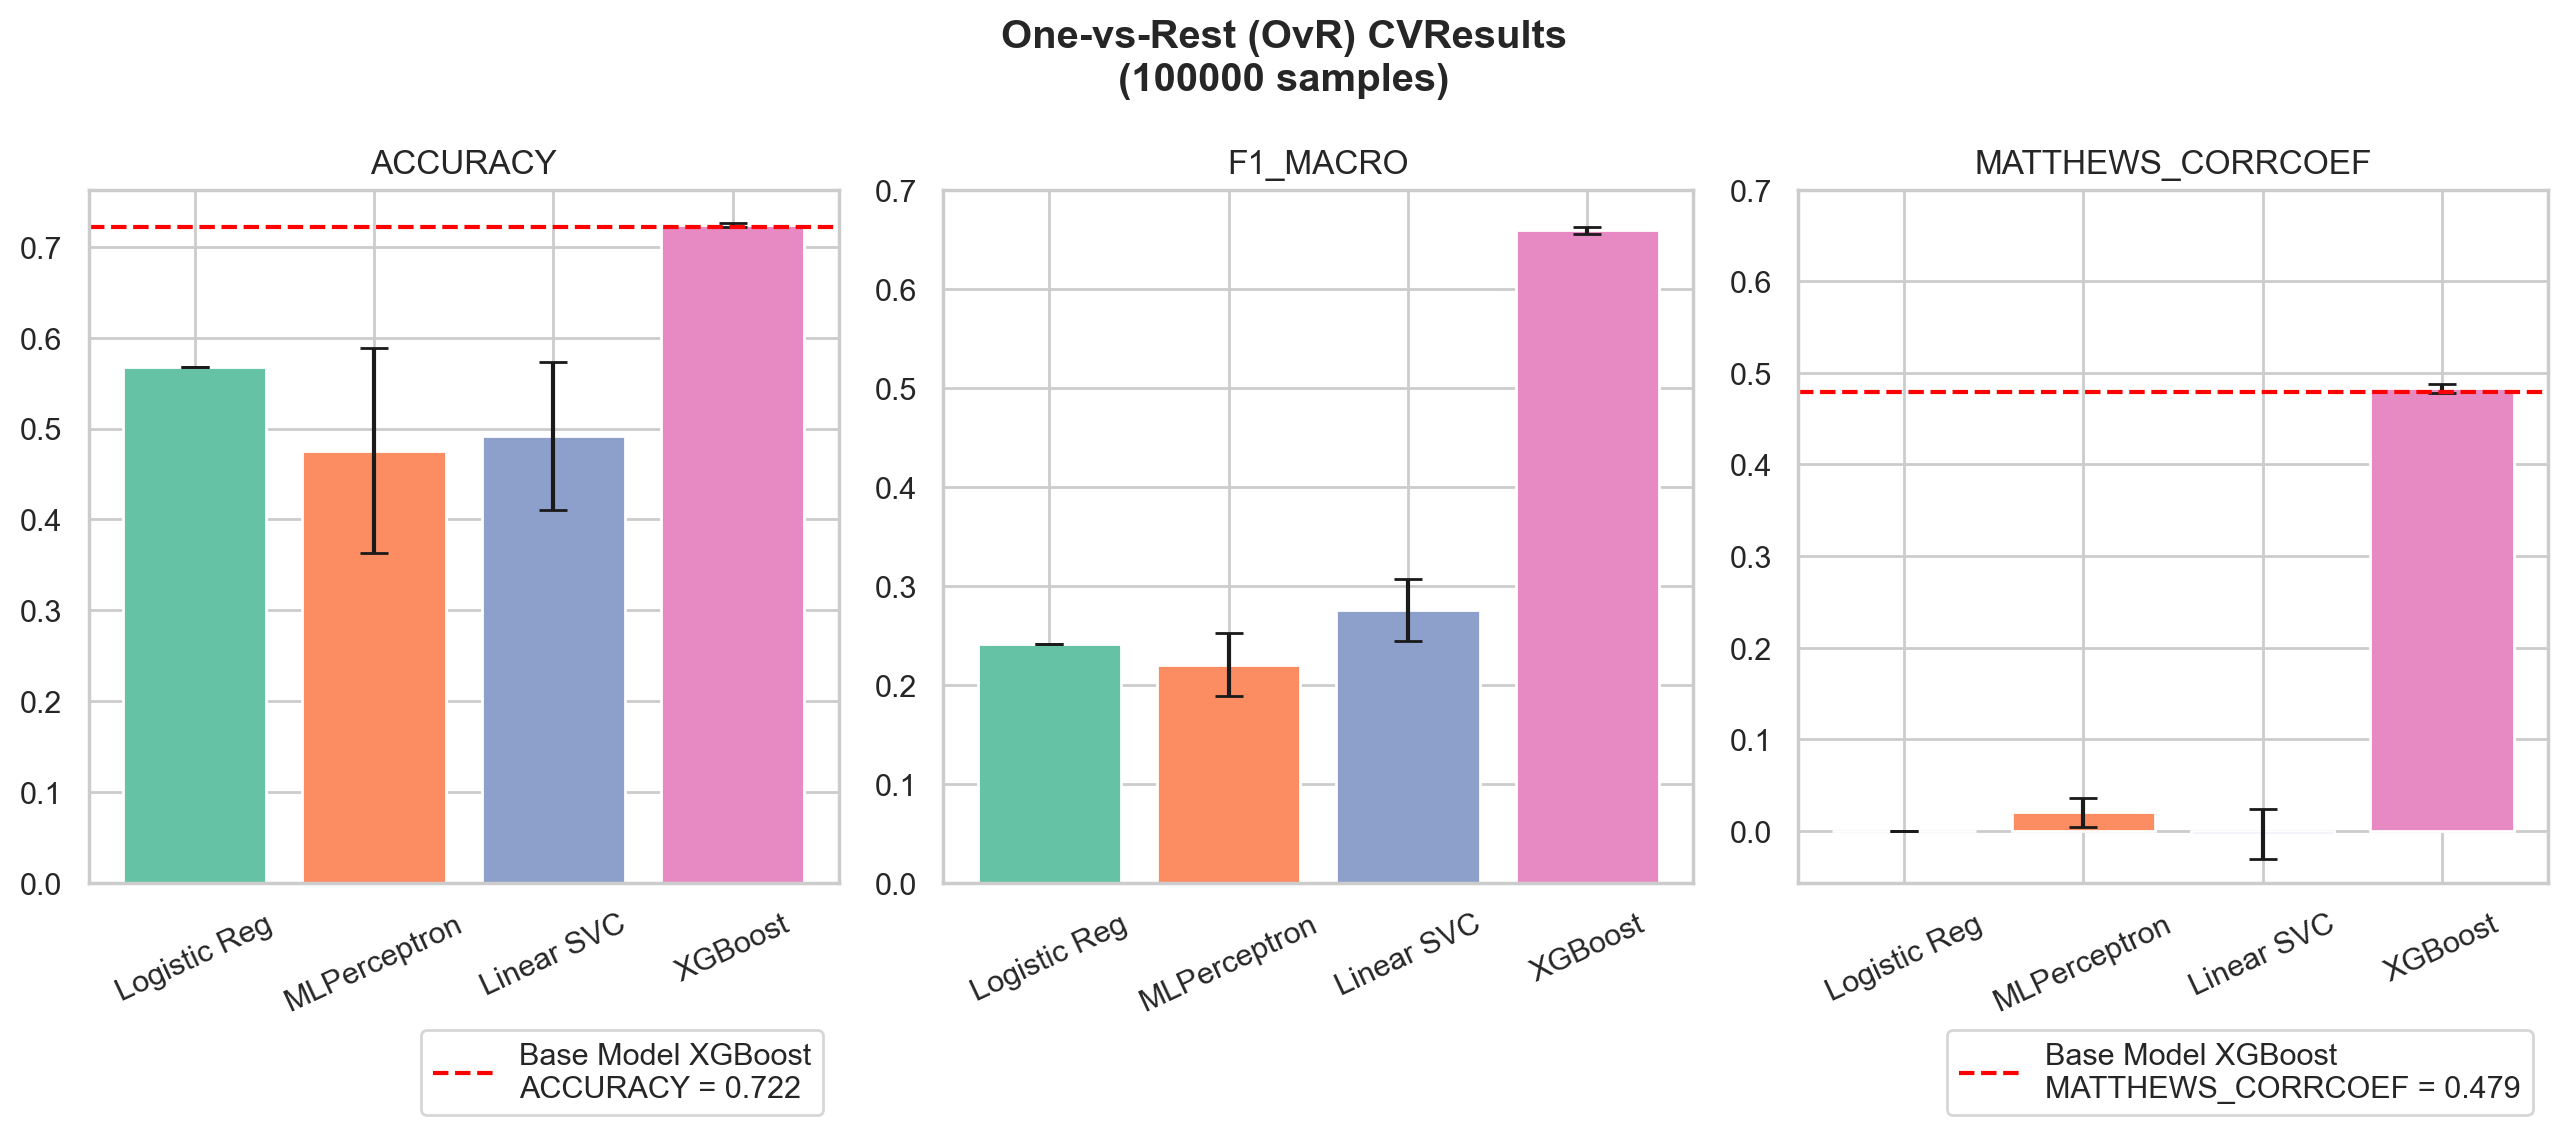

In [13]:
# compare results in a stacked plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(13, 6))

# define data
models_ovr = ['Logistic Reg', 'MLPerceptron', 'Linear SVC', 'XGBoost']
scores_ovr = [scores_lr_ovr, scores_mlp_ovr, scores_lsvc_ovr, scores_xgb_ovr]
metrics = ['test_accuracy', 'test_f1_macro', 'test_matthews_corrcoef']

for i, metric in enumerate(metrics):
    # plot results
    ax[i].bar(x=models_ovr,
              height=[score[metric].mean() for score in scores_ovr],
              yerr=[score[metric].std() for score in scores_ovr],
              capsize=5,
              color=sns.color_palette('Set2')[:4])
    # plot base model for comparison
    if metric != 'test_f1_macro':
        ax[i].axhline(y=base_cv_results[metric].mean(),
                      color='red',
                      linestyle='--',
                      label=f'Base Model XGBoost' + '\n' + f'{metric[5:].upper()} = {base_cv_results[metric].mean():.3f}')
            # set legend
        ax[i].legend(bbox_to_anchor=(1.0, -0.19))
    # set labels
    ax[i].tick_params(axis='x', rotation=25)
    # set title
    ax[i].set_title(metric[5:].upper())
    # set y axis ticks
    ax[i].set_yticks(np.arange(0, 0.75, 0.1))

fig.suptitle('One-vs-Rest (OvR) CVResults' + '\n' + f'({sample_size} samples)' , fontweight='bold')

plt.tight_layout()
plt.show()

fig.savefig('../../data/figures/ovr_cvresults.svg', dpi=300)

192.09711556434632 72.392
192.09711556434632 65.91712892271855
192.09711556434632 48.299595183803596


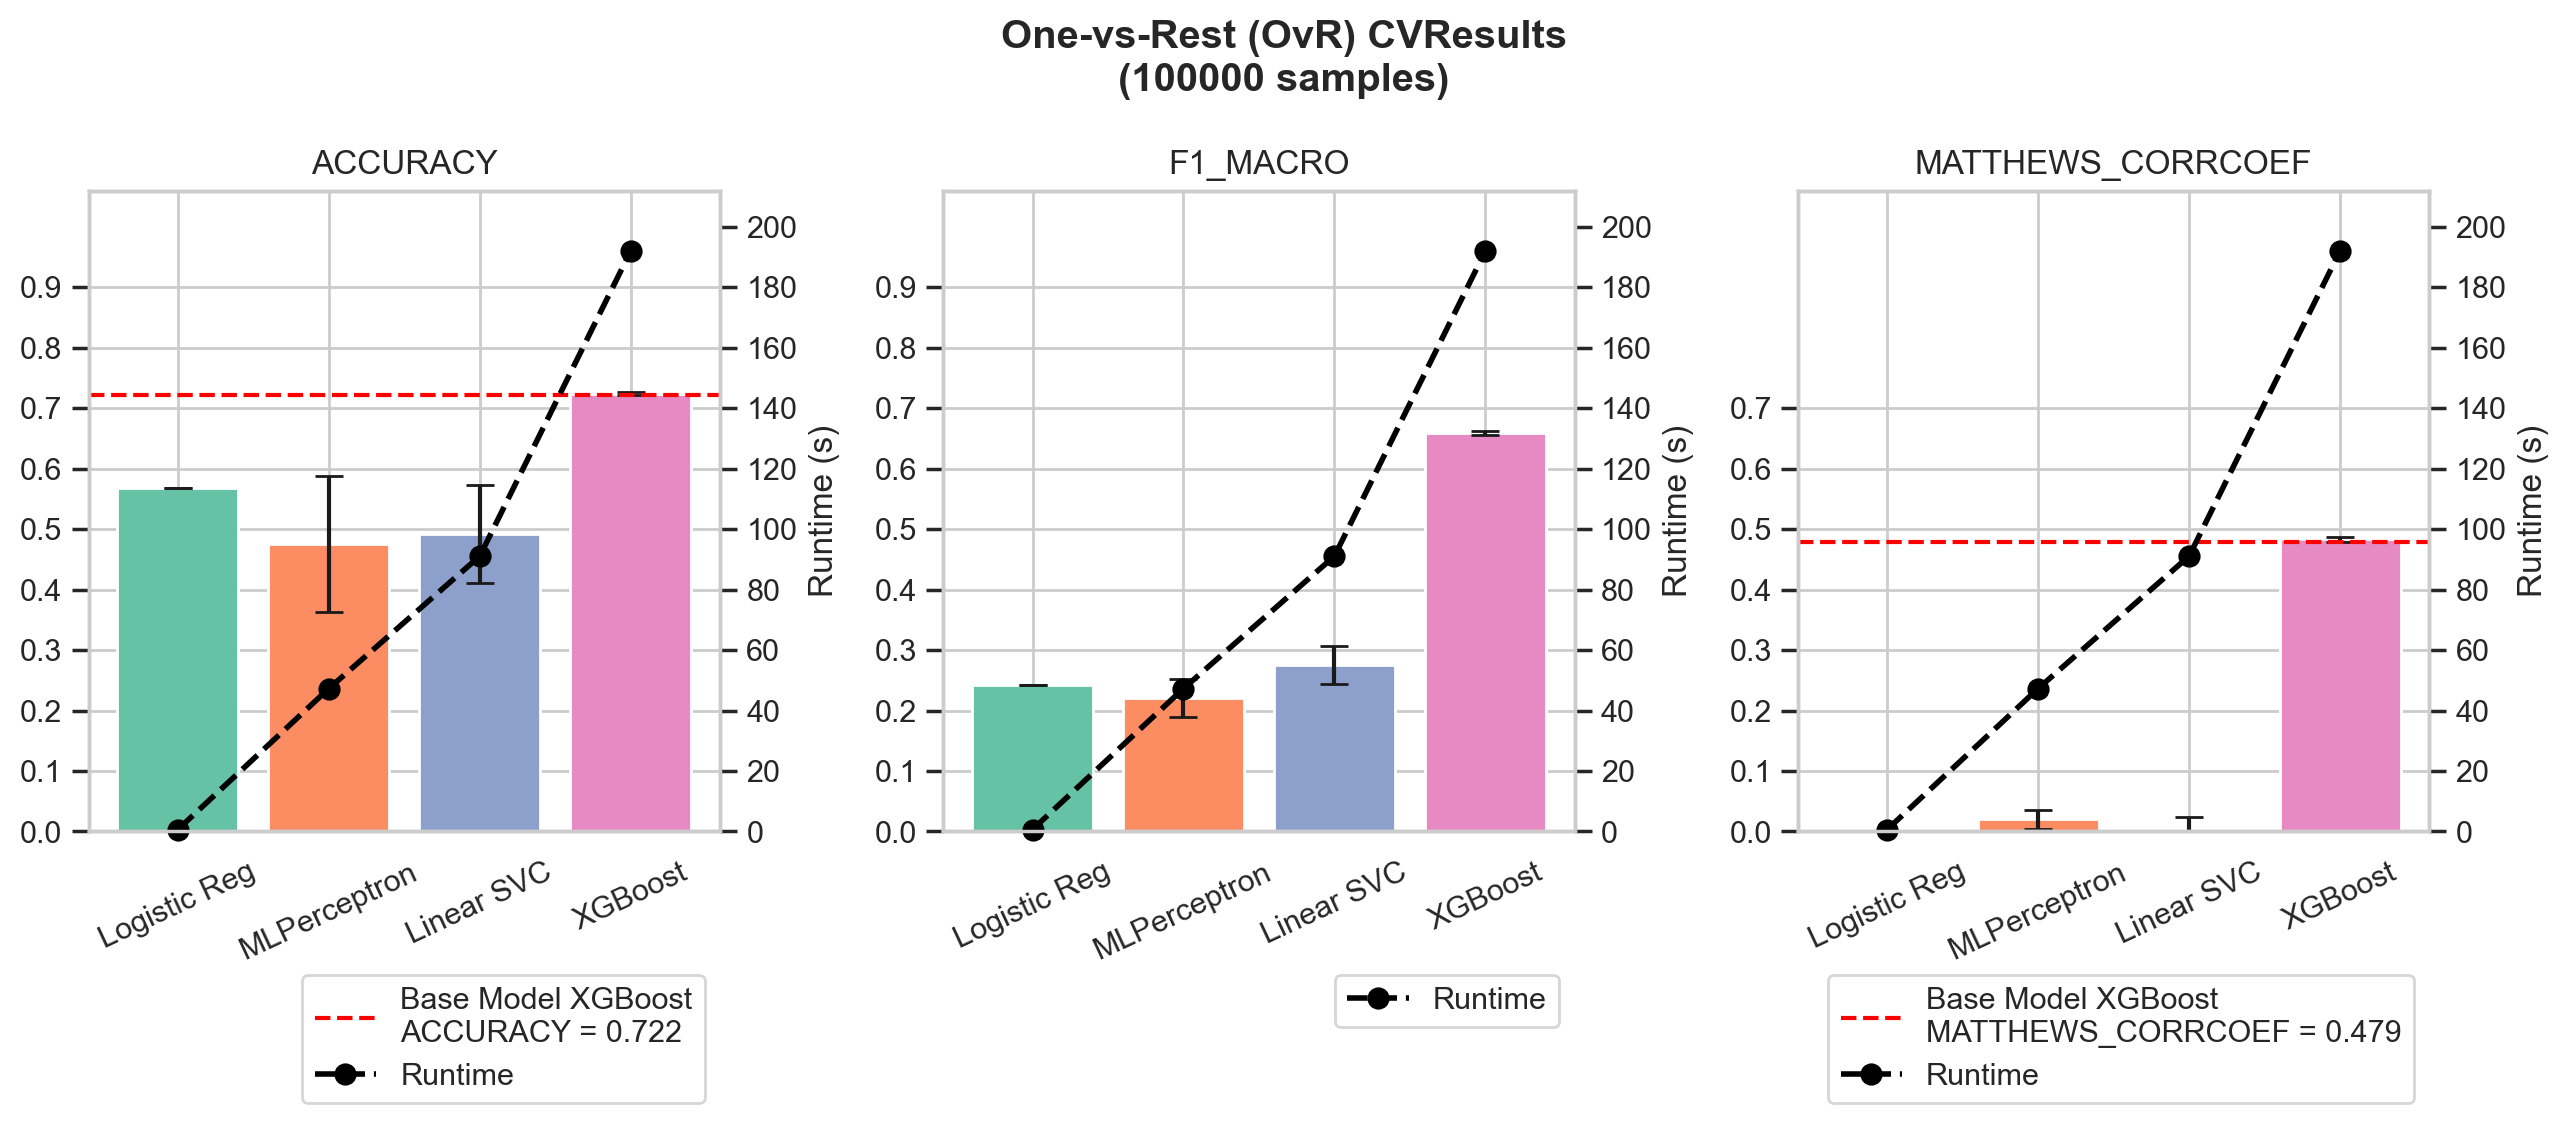

In [102]:
# compare results in a stacked plot tacking runtime into account by using a secondary y-axis
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(13, 6))

for i, metric in enumerate(metrics):
    # plot metric results
    ax[i].bar(x=models_ovr,
              height=[score[metric].mean() for score in scores_ovr],
              yerr=[score[metric].std() for score in scores_ovr],
              capsize=5,
              color=sns.color_palette('Set2')[:4])

    # plot base model for comparison
    if metric != 'test_f1_macro':
        ax[i].axhline(y=base_cv_results[metric].mean(),
                      color='red',
                      linestyle='--',
                      label=f'Base Model XGBoost' + '\n' + f'{metric[5:].upper()} = {base_cv_results[metric].mean():.3f}')
    # set title
    ax[i].set_title(metric[5:].upper())
    # set x-axis labels
    ax[i].tick_params(axis='x', rotation=25)
    # set legend parameters
    handles1, labels1 = ax[i].get_legend_handles_labels()
    # get max
    y_max = max([score[metric].mean() for score in scores_ovr])
    y_max_r = round(y_max, 1) + 0.25

    # plot runtime
    ax2 = ax[i].twinx()
    ax2.plot(models_ovr,
             [score['fit_time'].mean() for score in scores_ovr],
             color='black',
             marker='o',
             linestyle='--',
             linewidth=2,
             markersize=7,
             label='Runtime',
             clip_on=False)
    # set y-axis label, ticks and limits
    ax2.set_ylabel('Runtime (s)')
    ax2.grid(False)
    # set legend parameters
    handles2, labels2 = ax2.get_legend_handles_labels()
    # get max
    y_max_runtime = max([score['fit_time'].mean() for score in scores_ovr])
    y_max_runtime_r = round(y_max_runtime) + 20

    # set y-axes
    print(y_max_runtime, y_max*100)
    if (y_max_runtime_r/20)*0.1 >= y_max_r:
        ax2.set_yticks(np.arange(0, y_max_runtime_r, 20))
        ax2.set_ylim(0, y_max_runtime_r)
        ax[i].set_yticks(np.arange(0, y_max_r, 0.1))
        ax[i].set_ylim(0, (y_max_runtime_r/20)*0.1)
    else:
        ax[i].set_yticks(np.arange(0, y_max_r, 0.1))
        ax[i].set_ylim(0, y_max_r)
        ax2.set_yticks(np.arange(0, y_max_r*100, 10))
        ax2.set_ylim(0, y_max_r*100)

    # combine legends
    ax[i].legend(handles1+handles2, labels1+labels2, bbox_to_anchor=(1.0, -0.2))

# set figure title
fig.suptitle('One-vs-Rest (OvR) CVResults' + '\n' + f'({sample_size} samples)' , fontweight='bold')

plt.tight_layout()
plt.show()

fig.savefig('../../data/figures/ovr_cvresults_wruntime.svg', dpi=300)

**Findings:**
- Logistic Regression perform best and also surprisingly well in terms of $ACC = 0.567 +/- 0.000$ and $f1-score = 0.241 +/- 0.000$, but still does not reach the performance of the base model XGBoost which performs a CV Test $ACC = 0.7116 +/- 0.0026$ and CV Test $MCC = 0.4585 +/- 0.0051$.
- MLP as well as Linear SVC perform, as also experienced previously, significantly worse than the base model.
- Interesting ist tough, that the runtime of the base model is significantly higher than the runtime of the other models even-though it is all trained on the same dataset with the same CV settings.
- Regarding the runtime, Logistic Regression is the fastest model, followed by MLP, Linear SVC and XGBoost. It is also to mention that the runtime does not always match the performance, as for example Logistic Regression is the fastest model but also performs second best in terms of accuracy and f1-score. Whereas MLP and Linear SVC are the slowest models and take more time but also perform worst in terms of accuracy and f1-score. --> **More time and effort does not always mean better performance.**

## 2. One-vs-one (OvO)
Reference: "Pattern Recognition and Machine Learning" 2006 by Christopher M. Bishop, p.183

Like one-vs-rest, one-vs-one splits a multi-class classification dataset into binary classification problems. Unlike one-vs-rest that splits it into one binary dataset for each class, the one-vs-one approach splits the dataset into one dataset for each class versus every other class. This approach is suitable for algorithms that do not naturally predict a probability or score for each class, such as:
- **Support Vector Machine** and
- **k-Nearest Neighbors**.

Therefor these are tested using the implementation in scikit-learn. **Logistic Regression**, **XGBoost** and **Linear SVC** are also tested using the OneVsOneClassifier wrapper for comparison. MLP is not tested because it is not suitable for multi-class classification without a probability or score for each class.

### Support Vector Machine

In [15]:
%%time
# define model
svc = SVC(random_state=42,
          max_iter=1000,
          decision_function_shape='ovo')

# cross validation
scores_svc_ovo = cross_validate(svc, X_train, y_train['damage_grade'], cv=5, scoring=['accuracy', 'f1_macro', 'matthews_corrcoef'], n_jobs=-1)

# print results
print(f"Accuracy: {scores_svc_ovo['test_accuracy'].mean():.3f} +/- {scores_svc_ovo['test_accuracy'].std():.3f}")
print(f"F1 Macro: {scores_svc_ovo['test_f1_macro'].mean():.3f} +/- {scores_svc_ovo['test_f1_macro'].std():.3f}")
print(f"MCC: {scores_svc_ovo['test_matthews_corrcoef'].mean():.3f} +/- {scores_svc_ovo['test_matthews_corrcoef'].std():.3f}")
print('-'*20)
print(f"With Runtime: {scores_svc_ovo['fit_time'].mean():.3f} +/- {scores_svc_ovo['fit_time'].std():.3f}")
print('-'*20)

Accuracy: 0.235 +/- 0.072
F1 Macro: 0.209 +/- 0.060
MCC: -0.000 +/- 0.003
--------------------
With Runtime: 58.234 +/- 0.290
--------------------
CPU times: total: 15.6 ms
Wall time: 1min 24s


### KNN

In [16]:
%%time
# define model
knn = KNeighborsClassifier(n_neighbors=5,
                           n_jobs=-1)

# define the ovo strategy
ovo = OneVsOneClassifier(knn)

# cross validation
scores_knn_ovo = cross_validate(ovo, X_train, y_train['damage_grade'], cv=5, scoring=['accuracy', 'f1_macro', 'matthews_corrcoef'], n_jobs=-1)

# print results
print(f"Accuracy: {scores_knn_ovo['test_accuracy'].mean():.3f} +/- {scores_knn_ovo['test_accuracy'].std():.3f}")
print(f"F1 Macro: {scores_knn_ovo['test_f1_macro'].mean():.3f} +/- {scores_knn_ovo['test_f1_macro'].std():.3f}")
print(f"MCC: {scores_knn_ovo['test_matthews_corrcoef'].mean():.3f} +/- {scores_knn_ovo['test_matthews_corrcoef'].std():.3f}")
print('-'*20)
print(f"With Runtime: {scores_knn_ovo['fit_time'].mean():.3f} +/- {scores_knn_ovo['fit_time'].std():.3f}")
print('='*20)

Accuracy: 0.498 +/- 0.001
F1 Macro: 0.319 +/- 0.001
MCC: -0.003 +/- 0.001
--------------------
With Runtime: 0.088 +/- 0.008
CPU times: total: 31.2 ms
Wall time: 32.3 s


# Linear SVC

In [17]:
%%time
# define ovo strategy
ovo = OneVsOneClassifier(LinearSVC(random_state=42,
                                   max_iter=1000))

# cross validation
scores_lsvc_ovo = cross_validate(ovo, X_train, y_train['damage_grade'], cv=5, scoring=['accuracy', 'f1_macro', 'matthews_corrcoef'], n_jobs=-1)

# print results
print(f"Accuracy: {scores_lsvc_ovo['test_accuracy'].mean():.3f} +/- {scores_lsvc_ovo['test_accuracy'].std():.3f}")
print(f"F1 Macro: {scores_lsvc_ovo['test_f1_macro'].mean():.3f} +/- {scores_lsvc_ovo['test_f1_macro'].std():.3f}")
print(f"MCC: {scores_lsvc_ovo['test_matthews_corrcoef'].mean():.3f} +/- {scores_lsvc_ovo['test_matthews_corrcoef'].std():.3f}")
print('-'*20)
print(f"With Runtime: {scores_lsvc_ovo['fit_time'].mean():.3f} +/- {scores_lsvc_ovo['fit_time'].std():.3f}")
print('='*20)

Accuracy: 0.328 +/- 0.118
F1 Macro: 0.222 +/- 0.042
MCC: 0.000 +/- 0.013
--------------------
With Runtime: 34.416 +/- 0.234
CPU times: total: 0 ns
Wall time: 36.1 s


### (XGBoost)

In [18]:
%%time
# define ovo strategy
ovo = OneVsOneClassifier(xgb)

# cross validation
scores_xgb_ovo = cross_validate(ovo, X_train, y_train['damage_grade'], cv=5, scoring=['accuracy', 'f1_macro', 'matthews_corrcoef'], n_jobs=-1)

# print results
print(f"Accuracy: {scores_xgb_ovo['test_accuracy'].mean():.3f} +/- {scores_xgb_ovo['test_accuracy'].std():.3f}")
print(f"F1 Macro: {scores_xgb_ovo['test_f1_macro'].mean():.3f} +/- {scores_xgb_ovo['test_f1_macro'].std():.3f}")
print(f"MCC: {scores_xgb_ovo['test_matthews_corrcoef'].mean():.3f} +/- {scores_xgb_ovo['test_matthews_corrcoef'].std():.3f}")
print('-'*20)
print(f"With Runtime: {scores_xgb_ovo['fit_time'].mean():.3f} +/- {scores_xgb_ovo['fit_time'].std():.3f}")
print('='*20)

Accuracy: 0.720 +/- 0.003
F1 Macro: 0.654 +/- 0.005
MCC: 0.475 +/- 0.006
--------------------
With Runtime: 70.108 +/- 0.349
CPU times: total: 46.9 ms
Wall time: 1min 13s


## (Logistic Regression)

In [19]:
%%time
# define ovo strategy
ovo = OneVsOneClassifier(lr)

# cross validation
scores_lr_ovo = cross_validate(ovo, X_train, y_train['damage_grade'], cv=5, scoring=['accuracy', 'f1_macro', 'matthews_corrcoef'], n_jobs=-1)

# print results
print(f"Accuracy: {scores_lr_ovo['test_accuracy'].mean():.3f} +/- {scores_lr_ovo['test_accuracy'].std():.3f}")
print(f"F1 Macro: {scores_lr_ovo['test_f1_macro'].mean():.3f} +/- {scores_lr_ovo['test_f1_macro'].std():.3f}")
print(f"MCC: {scores_lr_ovo['test_matthews_corrcoef'].mean():.3f} +/- {scores_lr_ovo['test_matthews_corrcoef'].std():.3f}")
print('-'*20)
print(f"With Runtime: {scores_lr_ovo['fit_time'].mean():.3f} +/- {scores_lr_ovo['fit_time'].std():.3f}")
print('='*20)

Accuracy: 0.568 +/- 0.000
F1 Macro: 0.241 +/- 0.000
MCC: 0.000 +/- 0.000
--------------------
With Runtime: 0.213 +/- 0.009
CPU times: total: 15.6 ms
Wall time: 505 ms


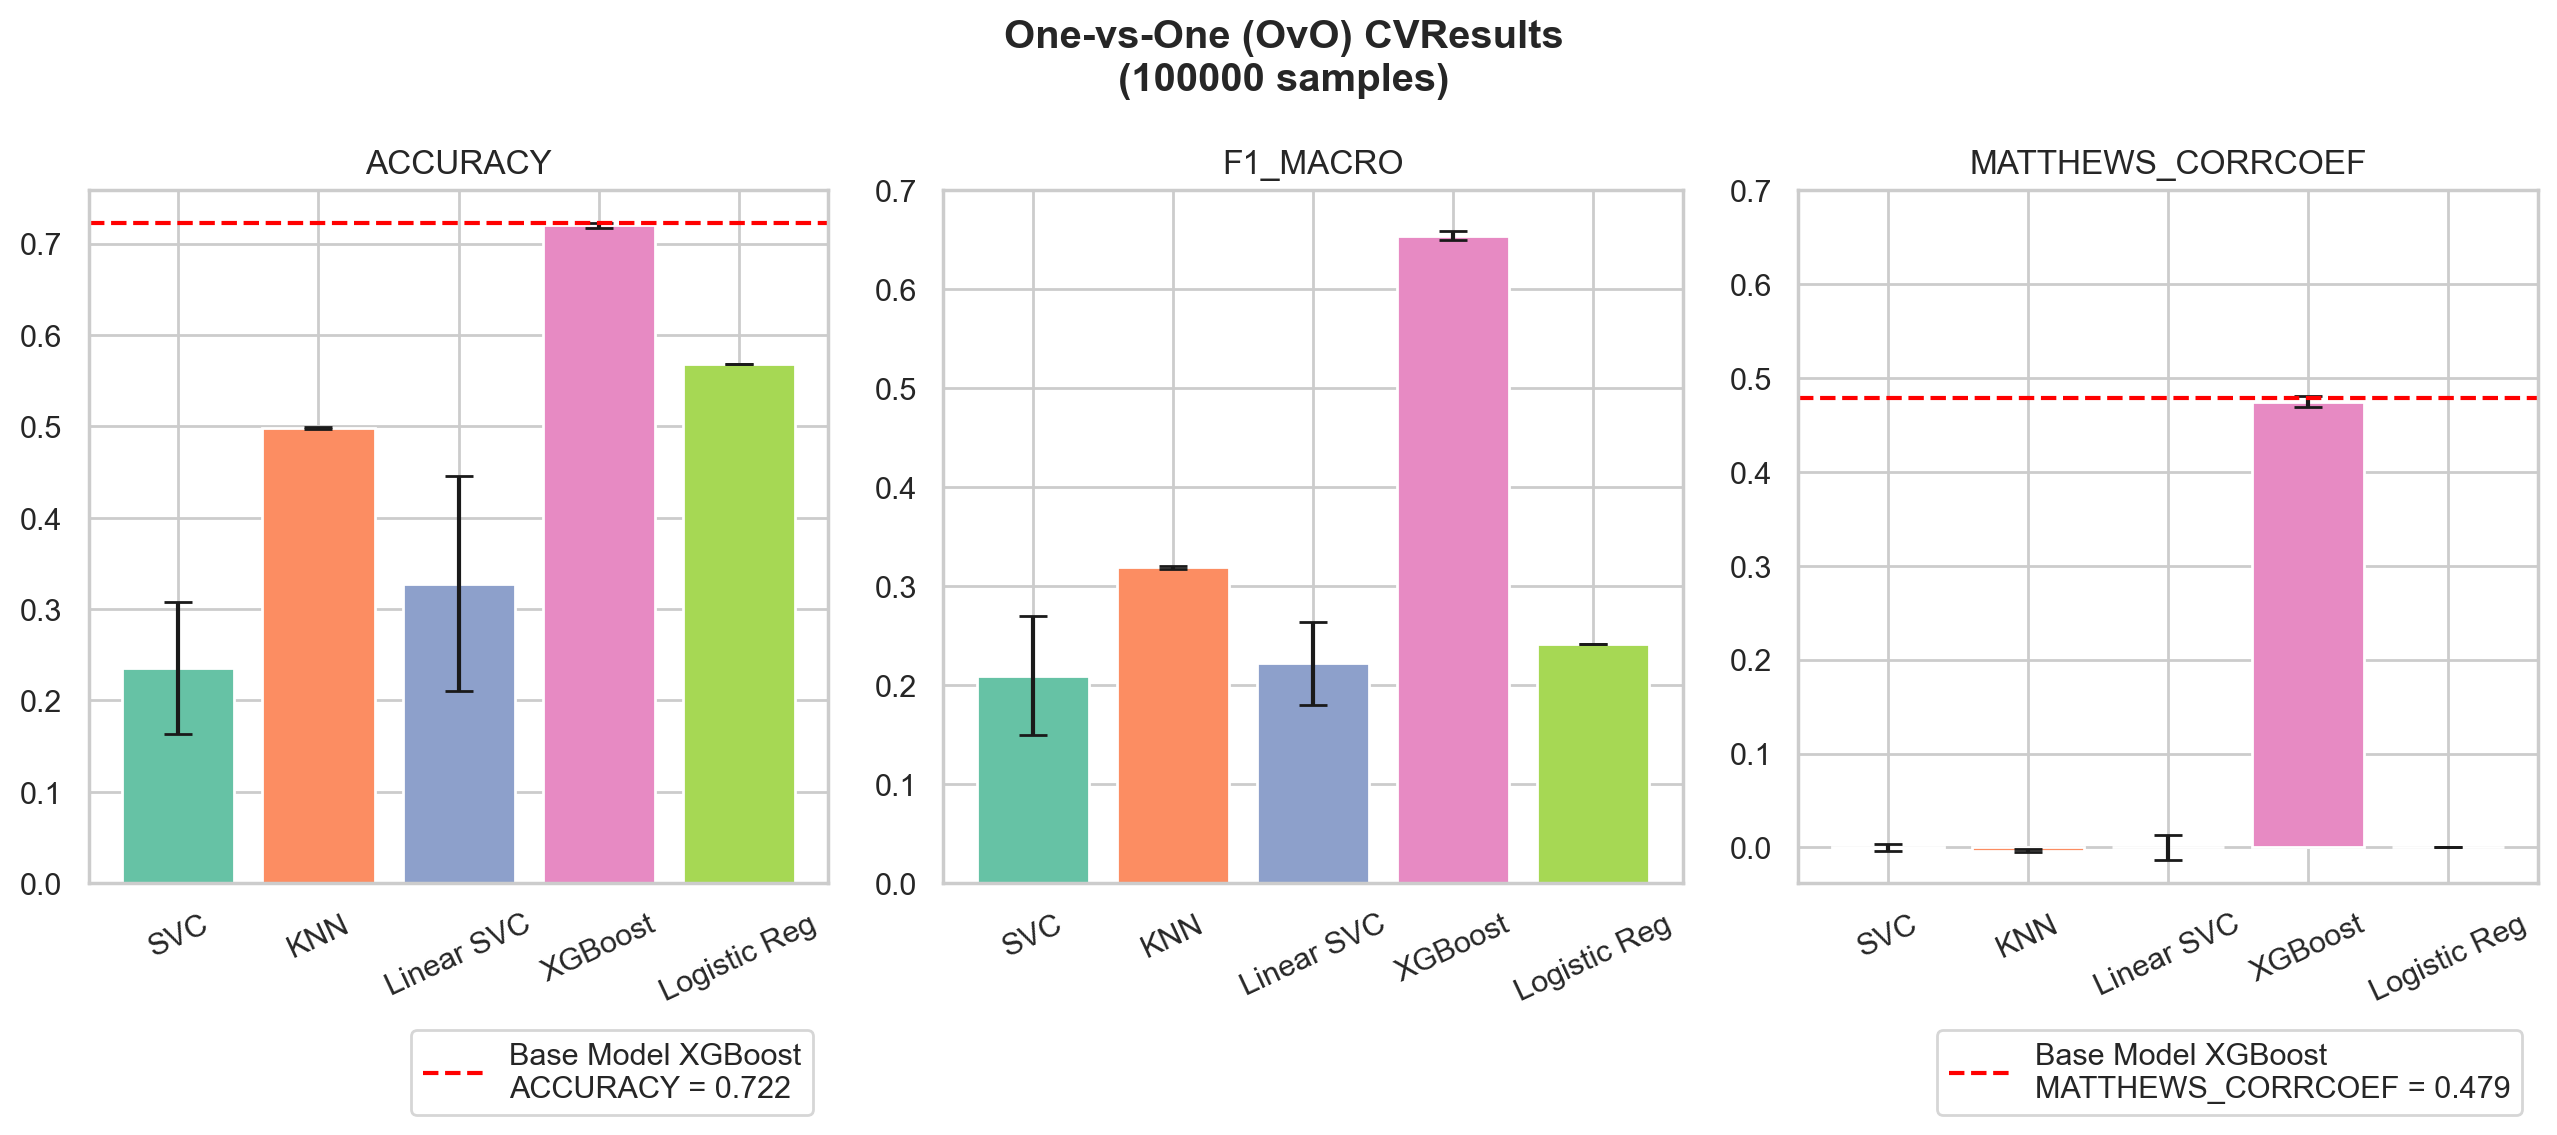

In [20]:
# compare results in a stacked plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(13, 6))

# define data
models_ovo = ['SVC', 'KNN', 'Linear SVC', 'XGBoost', 'Logistic Reg']
scores_ovo = [scores_svc_ovo, scores_knn_ovo, scores_lsvc_ovo, scores_xgb_ovo, scores_lr_ovo]
metrics = ['test_accuracy', 'test_f1_macro', 'test_matthews_corrcoef']

for i, metric in enumerate(metrics):
    # plot results
    ax[i].bar(x=models_ovo,
              height=[score[metric].mean() for score in scores_ovo],
              yerr=[score[metric].std() for score in scores_ovo],
              capsize=5,
              color=sns.color_palette('Set2')[:5])
    # plot base model for comparison
    if metric != 'test_f1_macro':
        ax[i].axhline(y=base_cv_results[metric].mean(),
                      color='red',
                      linestyle='--',
                      label=f'Base Model XGBoost' + '\n' + f'{metric[5:].upper()} = {base_cv_results[metric].mean():.3f}')
            # set legend
        ax[i].legend(bbox_to_anchor=(1.0, -0.19))
    # set labels
    ax[i].tick_params(axis='x', rotation=25)
    # set title
    ax[i].set_title(metric[5:].upper())
    # set y axis ticks
    ax[i].set_yticks(np.arange(0, 0.75, 0.1))

fig.suptitle('One-vs-One (OvO) CVResults' + '\n' + f'({sample_size} samples)' , fontweight='bold')

plt.tight_layout()
plt.show()

fig.savefig('../../data/figures/ovo_cvresults.svg', dpi=300)

70.10802412033081 71.98599999999999
70.10802412033081 65.38220004402908
70.10802412033081 47.45940638320956


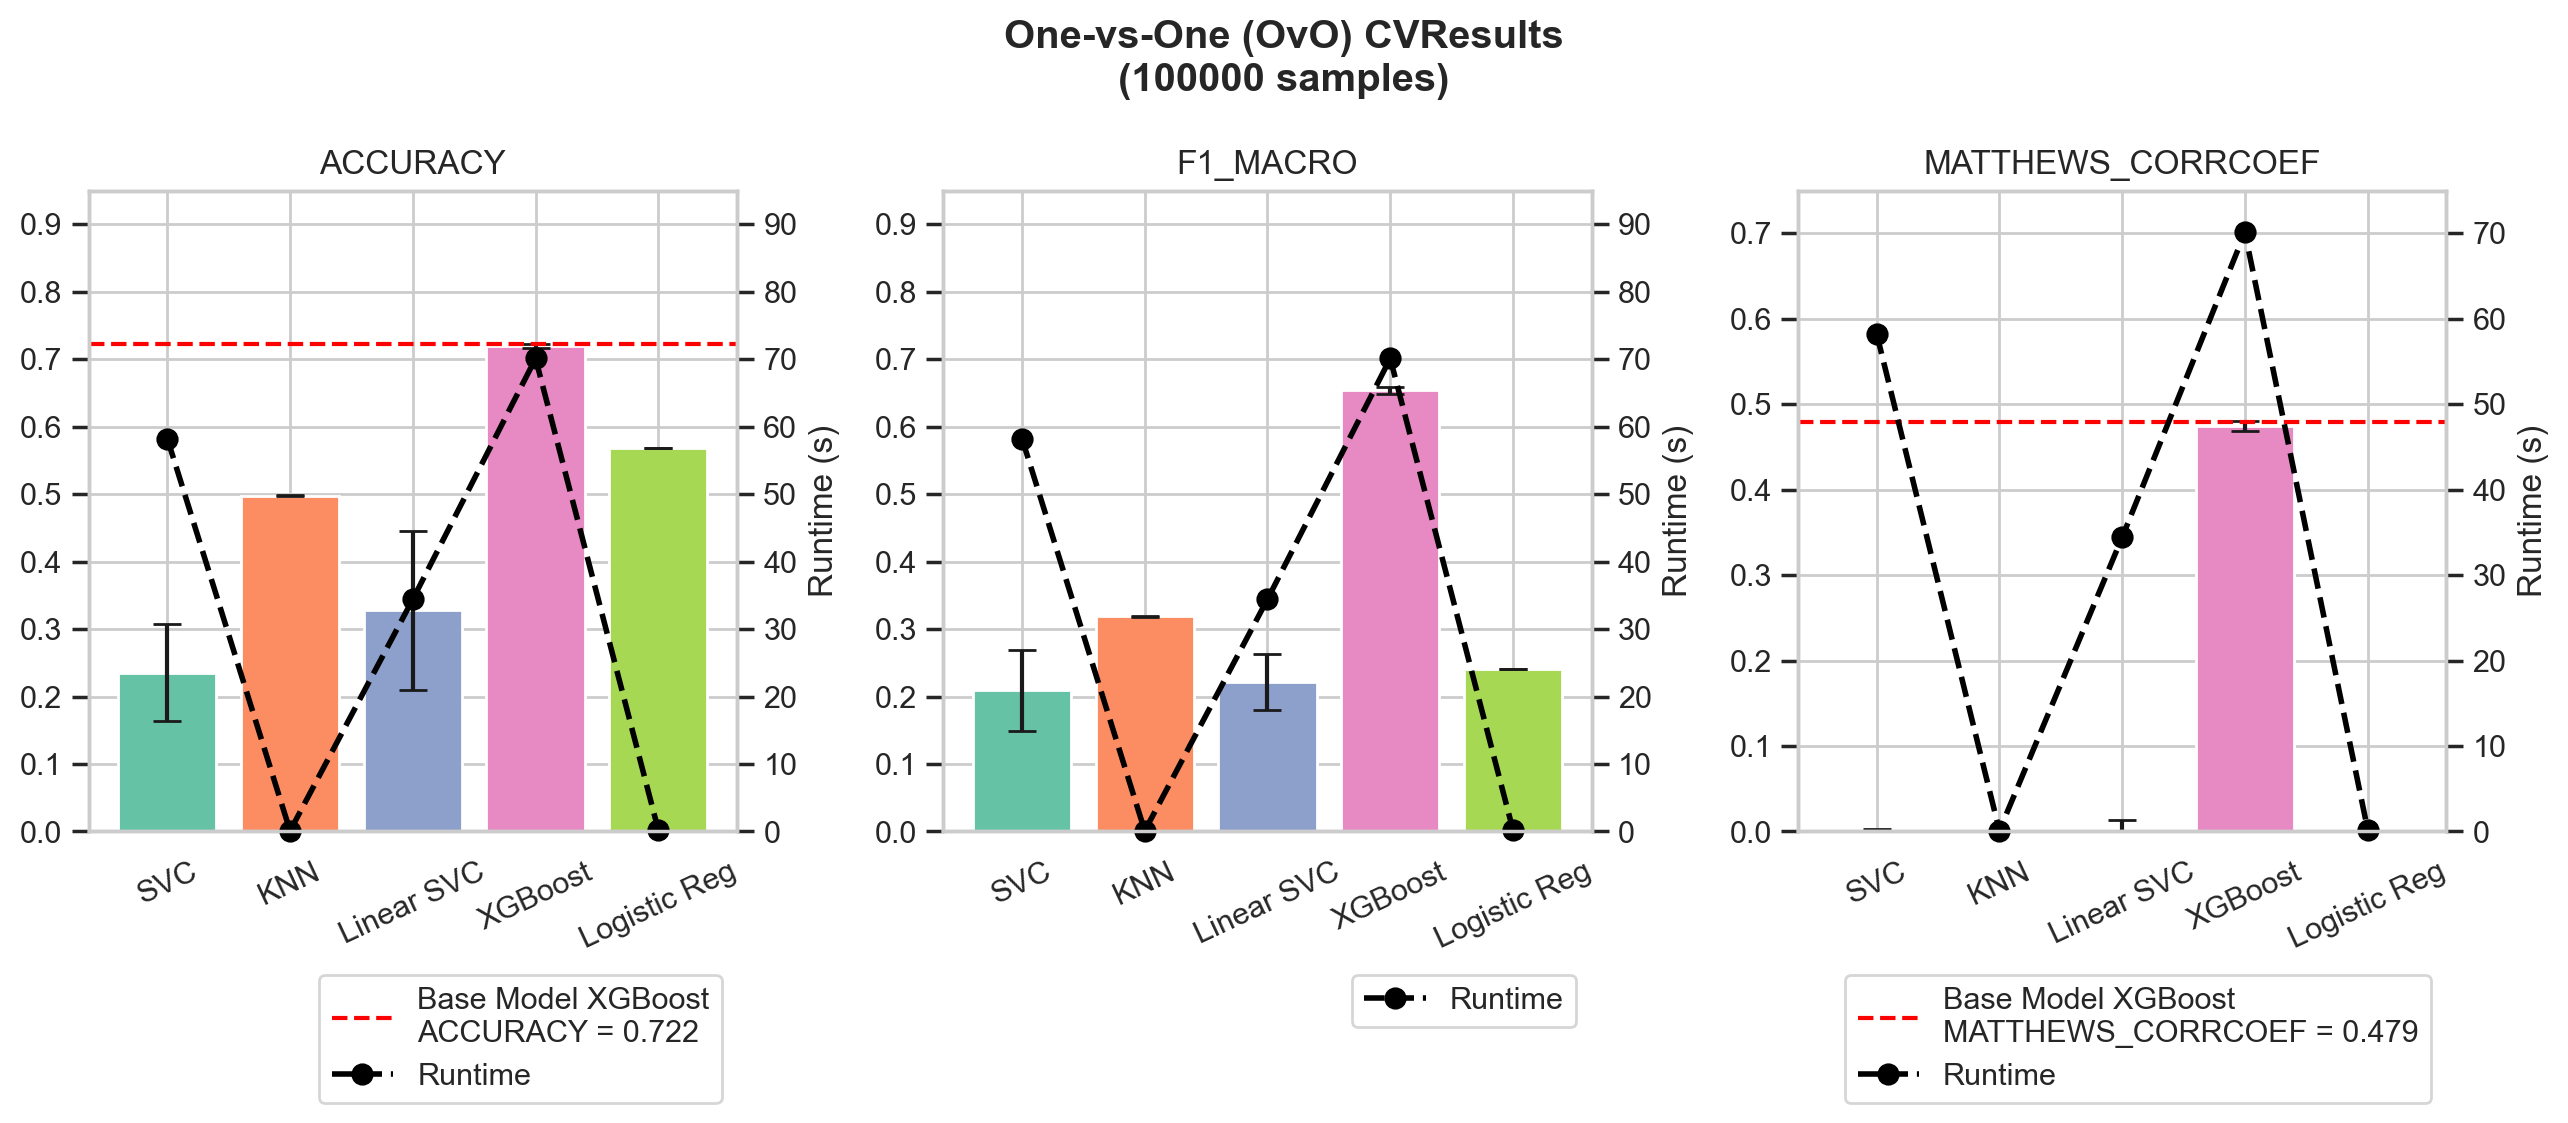

In [101]:
# compare results in a stacked plot tacking runtime into account by using a secondary y-axis
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(13, 6))

for i, metric in enumerate(metrics):
    # plot results
    ax[i].bar(x=models_ovo,
              height=[score[metric].mean() for score in scores_ovo],
              yerr=[score[metric].std() for score in scores_ovo],
              capsize=5,
              color=sns.color_palette('Set2')[:5])

    # plot base model for comparison
    if metric != 'test_f1_macro':
        ax[i].axhline(y=base_cv_results[metric].mean(),
                      color='red',
                      linestyle='--',
                      label=f'Base Model XGBoost' + '\n' + f'{metric[5:].upper()} = {base_cv_results[metric].mean():.3f}')
    # set title
    ax[i].set_title(metric[5:].upper())
    # set x-axis labels
    ax[i].tick_params(axis='x', rotation=25)
    # set legend parameters
    handles1, labels1 = ax[i].get_legend_handles_labels()
    # get max
    y_max = max([score[metric].mean() for score in scores_ovo])
    y_max_r = round(y_max, 1) + 0.25

    # plot runtime
    ax2 = ax[i].twinx()
    ax2.plot(models_ovo,
             [score['fit_time'].mean() for score in scores_ovo],
             color='black',
             marker='o',
             linestyle='--',
             linewidth=2,
             markersize=7,
             label='Runtime',
             clip_on=False)
    # set y-axis label, ticks and limits
    ax2.set_ylabel('Runtime (s)')
    ax2.grid(False)
    # set legend parameters
    handles2, labels2 = ax2.get_legend_handles_labels()
    # get max
    y_max_runtime = max([score['fit_time'].mean() for score in scores_ovo])
    y_max_runtime_r = round(y_max_runtime) + 20

    # set y-axes
    print(y_max_runtime, y_max*100)
    if (y_max_runtime_r/20)*0.1 >= y_max_r:
        ax2.set_yticks(np.arange(0, y_max_runtime_r, 20))
        ax2.set_ylim(0, y_max_runtime_r)
        ax[i].set_yticks(np.arange(0, y_max_r, 0.1))
        ax[i].set_ylim(0, (y_max_runtime_r/20)*0.1)
    else:
        ax[i].set_yticks(np.arange(0, y_max_r, 0.1))
        ax[i].set_ylim(0, y_max_r)
        ax2.set_yticks(np.arange(0, y_max_r*100, 10))
        ax2.set_ylim(0, y_max_r*100)

    # combine legends
    ax[i].legend(handles1+handles2, labels1+labels2, bbox_to_anchor=(1.0, -0.2))

# set figure title
fig.suptitle('One-vs-One (OvO) CVResults' + '\n' + f'({sample_size} samples)' , fontweight='bold')

plt.tight_layout()
plt.show()

fig.savefig('../../data/figures/ovo_cvresults_wruntime.svg', dpi=300)

**Findings:**
- Yet the results of the OvO strategy are very similar to the results of the OvR strategy, a few models perform slightly better using the OvO strategy, but the differences are not significant. One of these would be the Linear SVC model which increases by roughly 1.5 in accuracy.
- Also, the Matthews Correlation Coefficient is slightly higher using the OvO strategy for all models.
- The runtime is much lower using the OvO strategy, especially for the XGBoost model. This is a bit surprising, as the OvO strategy usually requires much more models to be trained. But it seems that the models are trained faster using the OvO strategy.
- However, the improvements in comparison to the OvR strategy and the base model performance are not significant enough to justify the additional complexity of the OvO strategy.

## 1. + 2. Compare OvO and OvR strategy

In [22]:
# models in both strategies to make a comparison plot of the results
models_both = [x for x in models_ovo if x in models_ovr]
models_both

['Linear SVC', 'XGBoost', 'Logistic Reg']

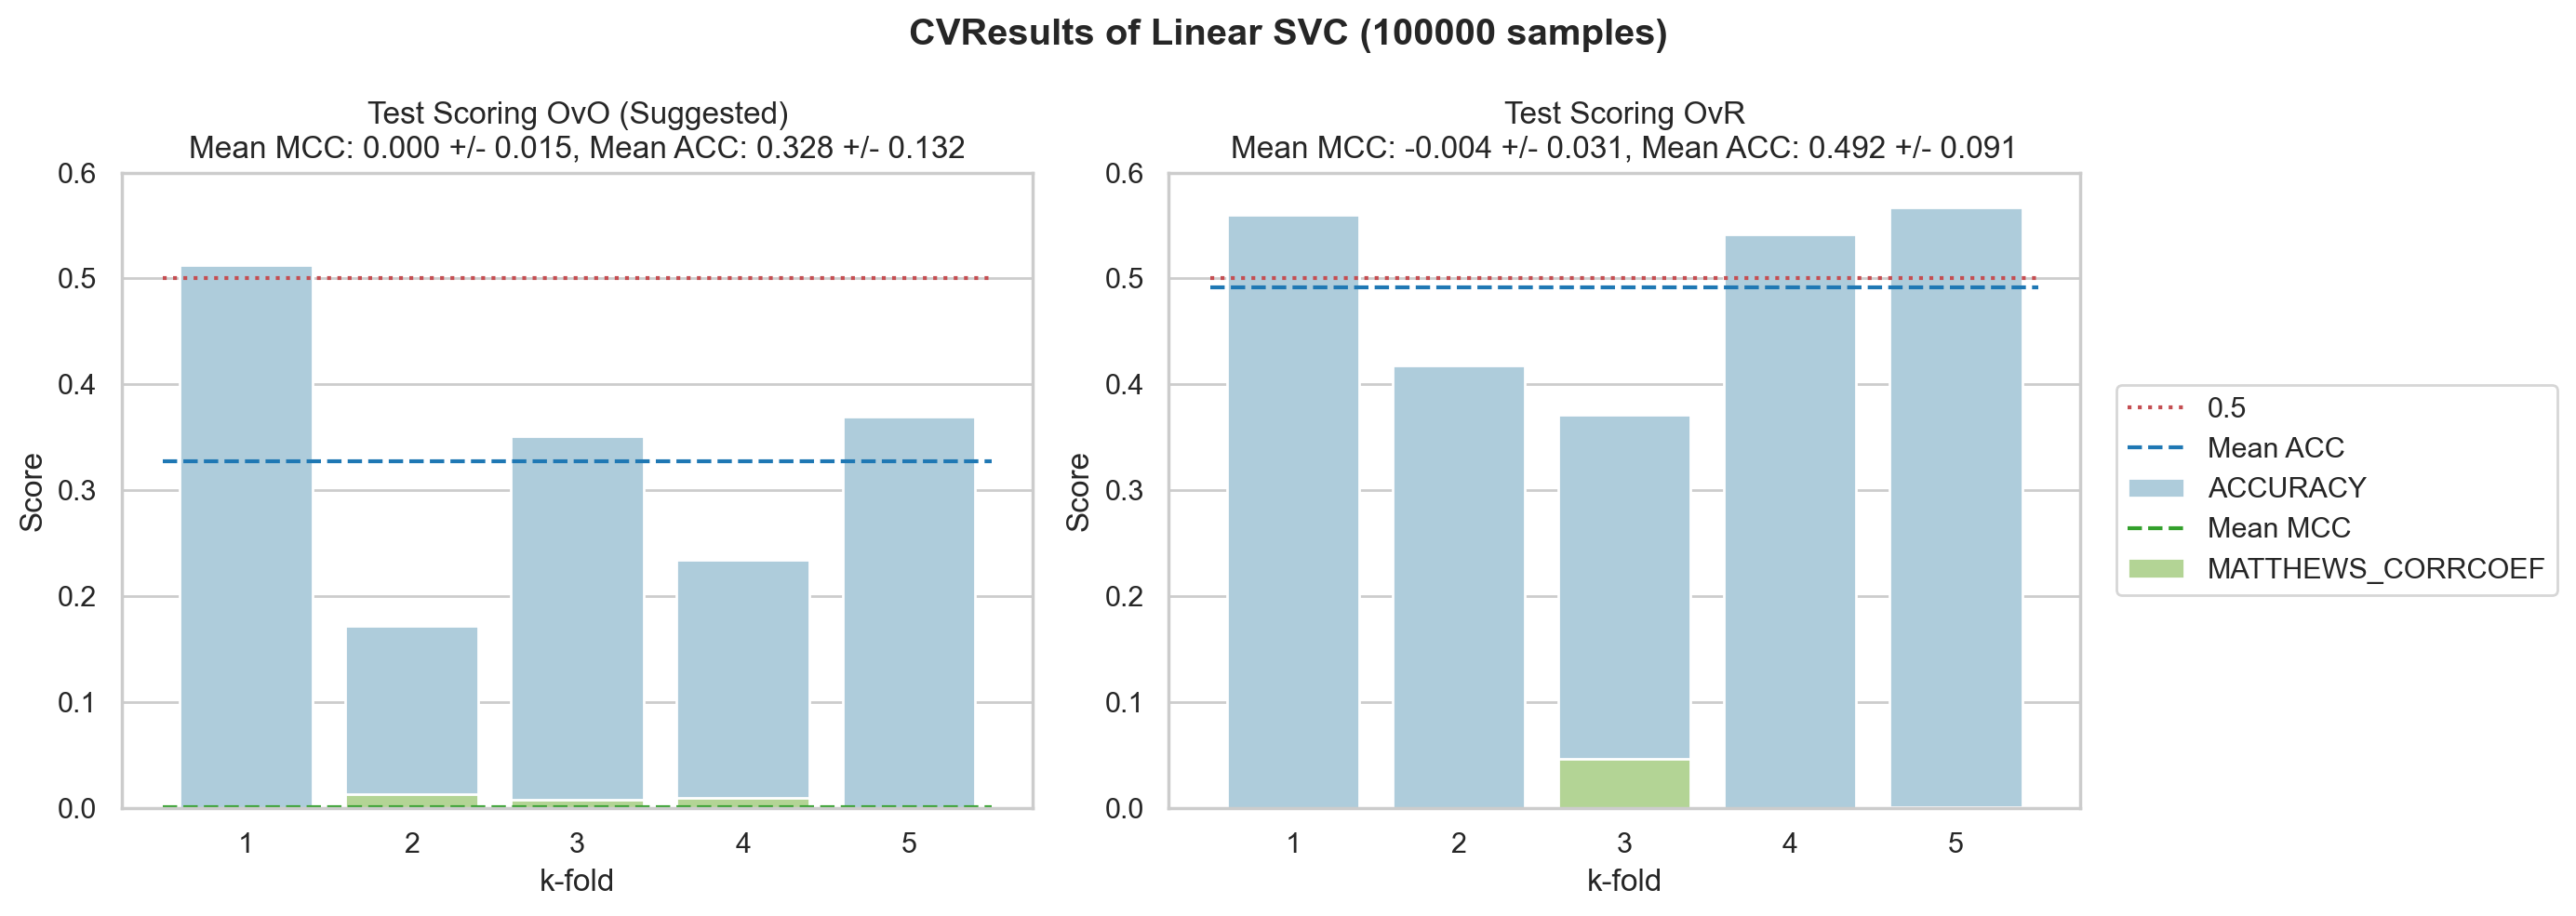

In [23]:
# compare linear svc models using meta-strategy OvO and OvR
compare_models_cv_acc_mcc([scores_lsvc_ovo, scores_lsvc_ovr], ['OvO (Suggested)', 'OvR'], sample_size, (0.0, 0.6), (14, 5), f"CVResults of Linear SVC ({sample_size} samples)")
fig.savefig('../../data/figures/ovo_ovr_lsvc.svg', dpi=300)

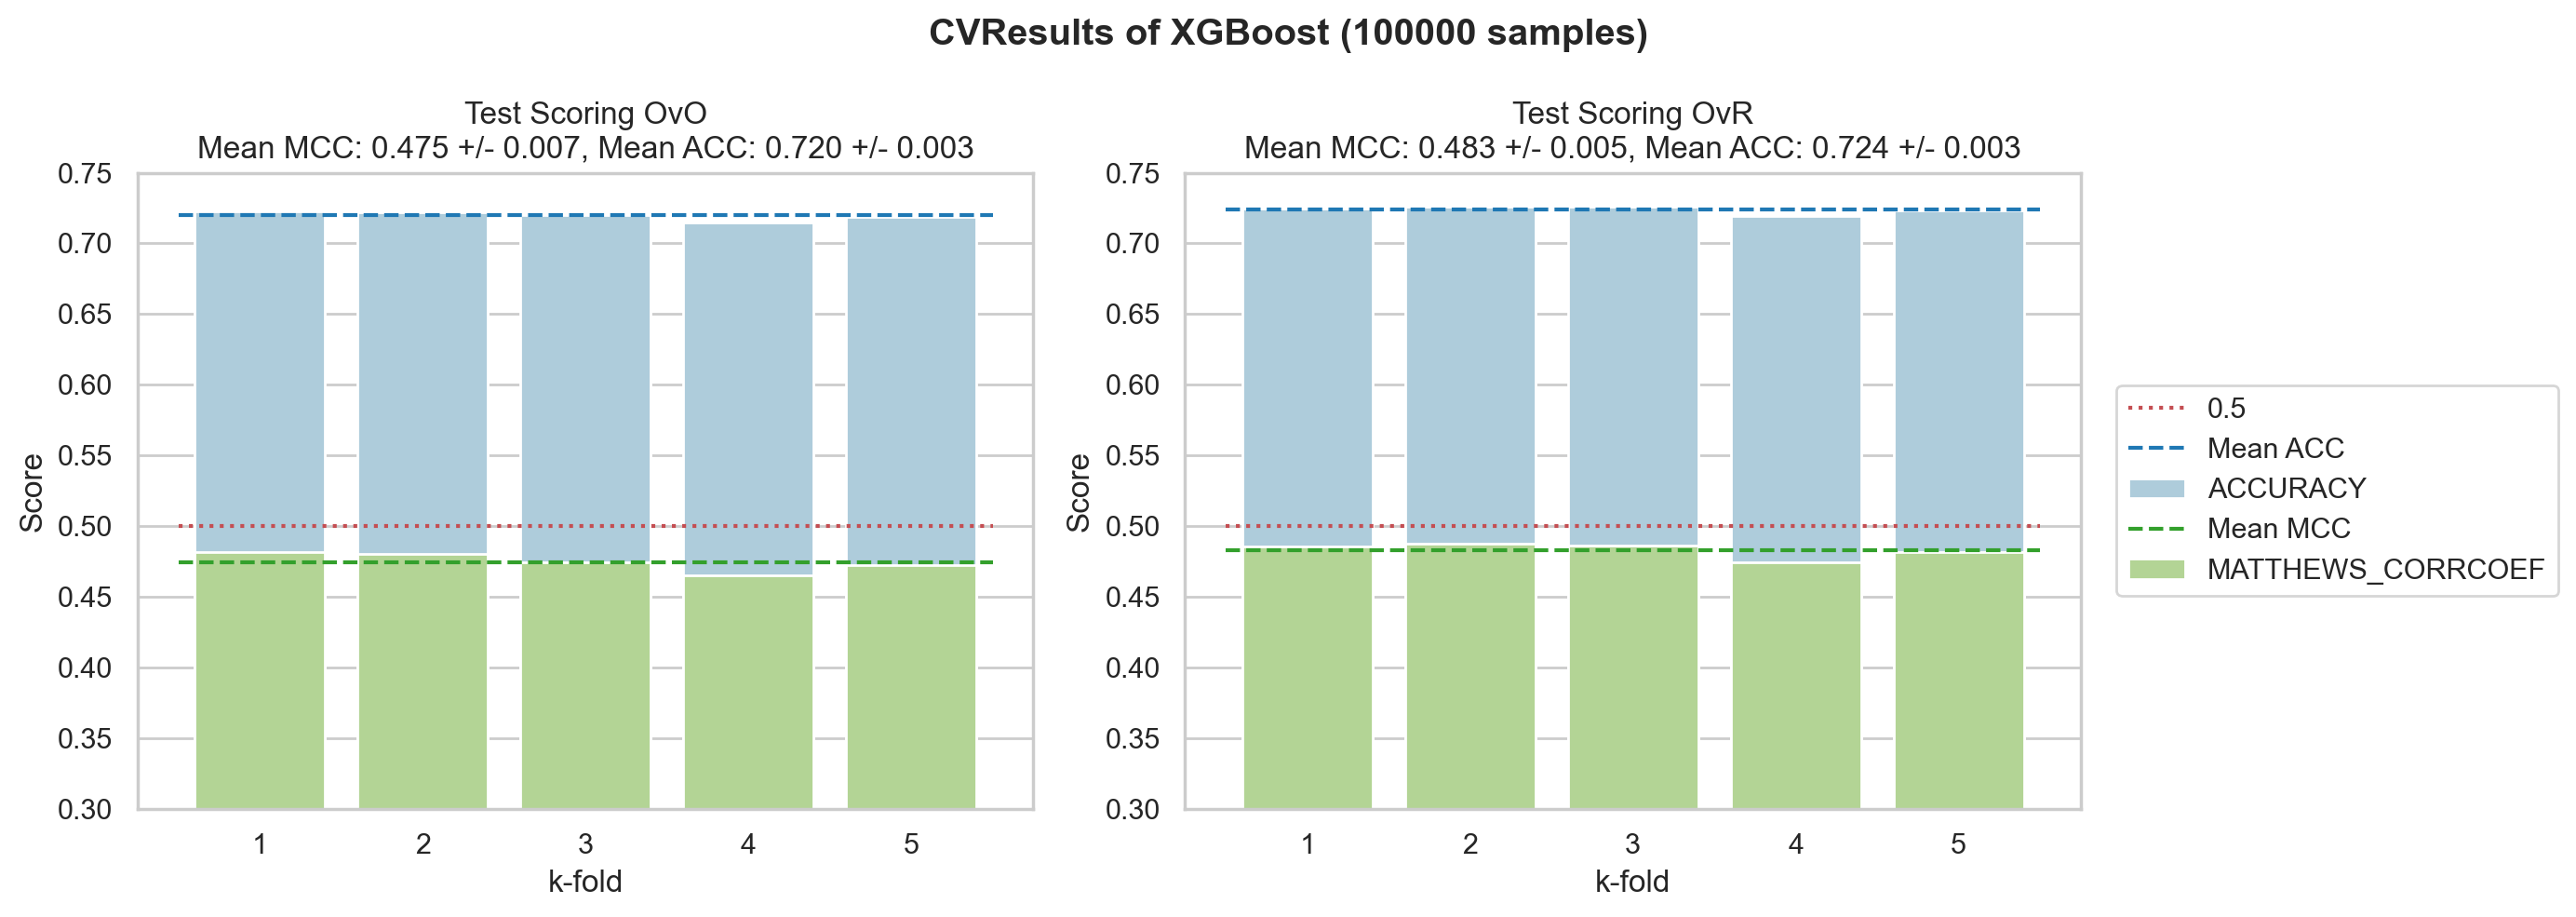

In [24]:
# compare xgb models using meta-strategy OvO and OvR
compare_models_cv_acc_mcc([scores_xgb_ovo, scores_xgb_ovr], ['OvO', 'OvR'], sample_size, (0.3, 0.75), (14, 5), f"CVResults of XGBoost ({sample_size} samples)")
fig.savefig('../../data/figures/ovo_ovr_xgb.svg', dpi=300)

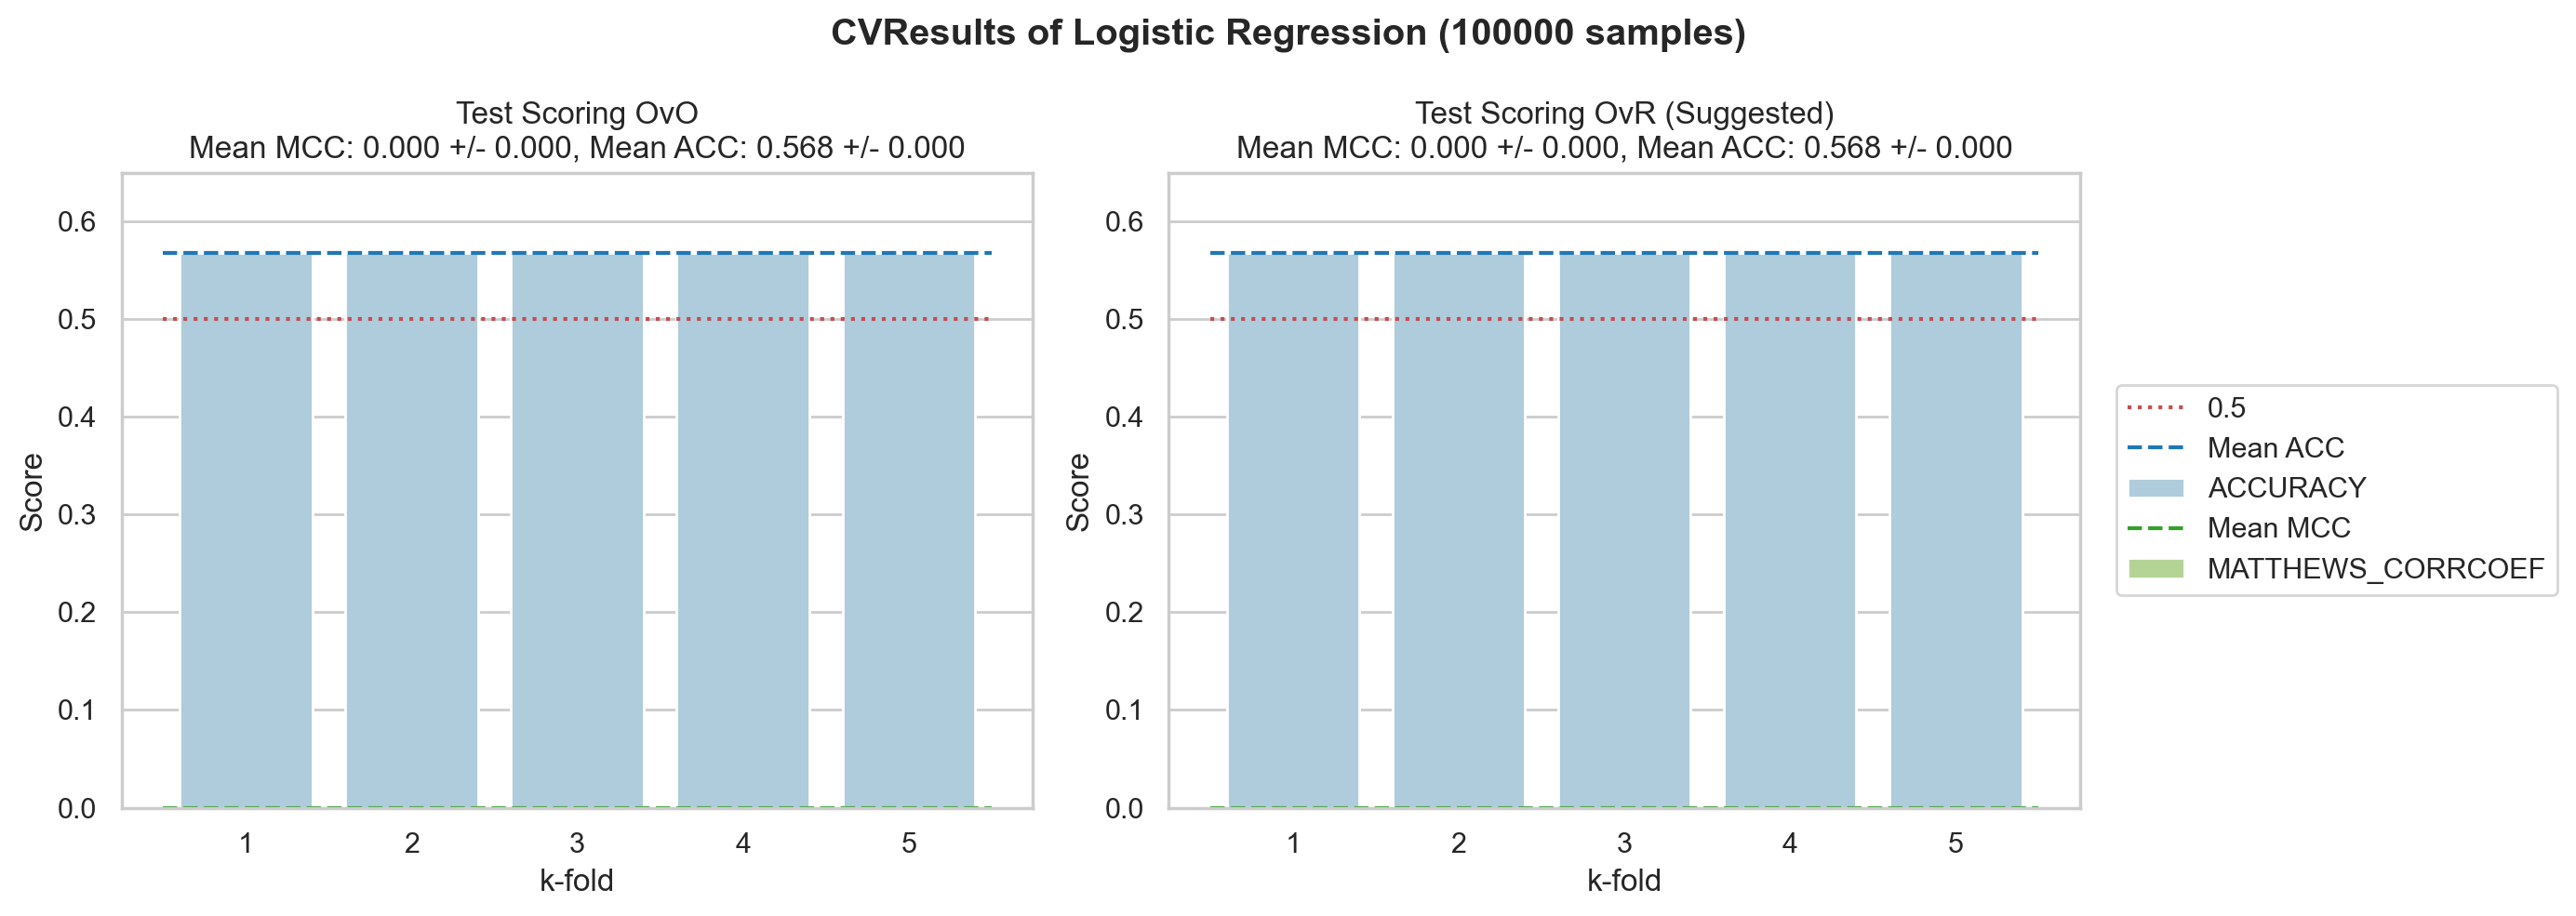

In [25]:
# compare lr models using meta-strategy OvO and OvR
compare_models_cv_acc_mcc([scores_lr_ovo, scores_lr_ovr], ['OvO', 'OvR (Suggested)'], sample_size, (0.0, 0.65), (14, 5), f"CVResults of Logistic Regression ({sample_size} samples)")
fig.savefig('../../data/figures/ovo_ovr_lr.svg', dpi=300)

**Findings:**
- The results of the OvO and OvR strategy are very similar for all models. The differences are not significant.
- The runtime is much lower using the OvO strategy, especially for the XGBoost model.
- No model, regardless using the OvR strategy or the OvO strategy, is able to outperform the base model XGBoost in terms of accuracy, f1-score and mcc. --> **Therefore, the base model XGBoost still gets used for further processing as is, OvR and OvO are not considered for further processing.**

## 3. Output Coding
Error-Correcting Output Code-based strategies.

### Linear SVC

In [26]:
%%time
# define output coding strategy
oc = OutputCodeClassifier(linear_svc, code_size=2, random_state=42)

# cross-validate model
scores_lsvc_oc = cross_validate(oc, X_train, y_train['damage_grade'], cv=5, scoring=['accuracy', 'f1_macro', 'matthews_corrcoef'], n_jobs=-1)

# print results
print(f"Accuracy: {scores_lsvc_oc['test_accuracy'].mean():.3f} +/- {scores_lsvc_oc['test_accuracy'].std():.3f}")
print(f"F1-Score: {scores_lsvc_oc['test_f1_macro'].mean():.3f} +/- {scores_lsvc_oc['test_f1_macro'].std():.3f}")
print(f"MCC: {scores_lsvc_oc['test_matthews_corrcoef'].mean():.3f} +/- {scores_lsvc_oc['test_matthews_corrcoef'].std():.3f}")
print('-'*20)
print(f"Runtime: {scores_lsvc_oc['fit_time'].mean():.3f} +/- {scores_lsvc_oc['fit_time'].std():.3f}")
print('='*20)

Accuracy: 0.539 +/- 0.033
F1-Score: 0.273 +/- 0.025
MCC: -0.006 +/- 0.008
--------------------
Runtime: 186.522 +/- 0.207
CPU times: total: 0 ns
Wall time: 3min 7s


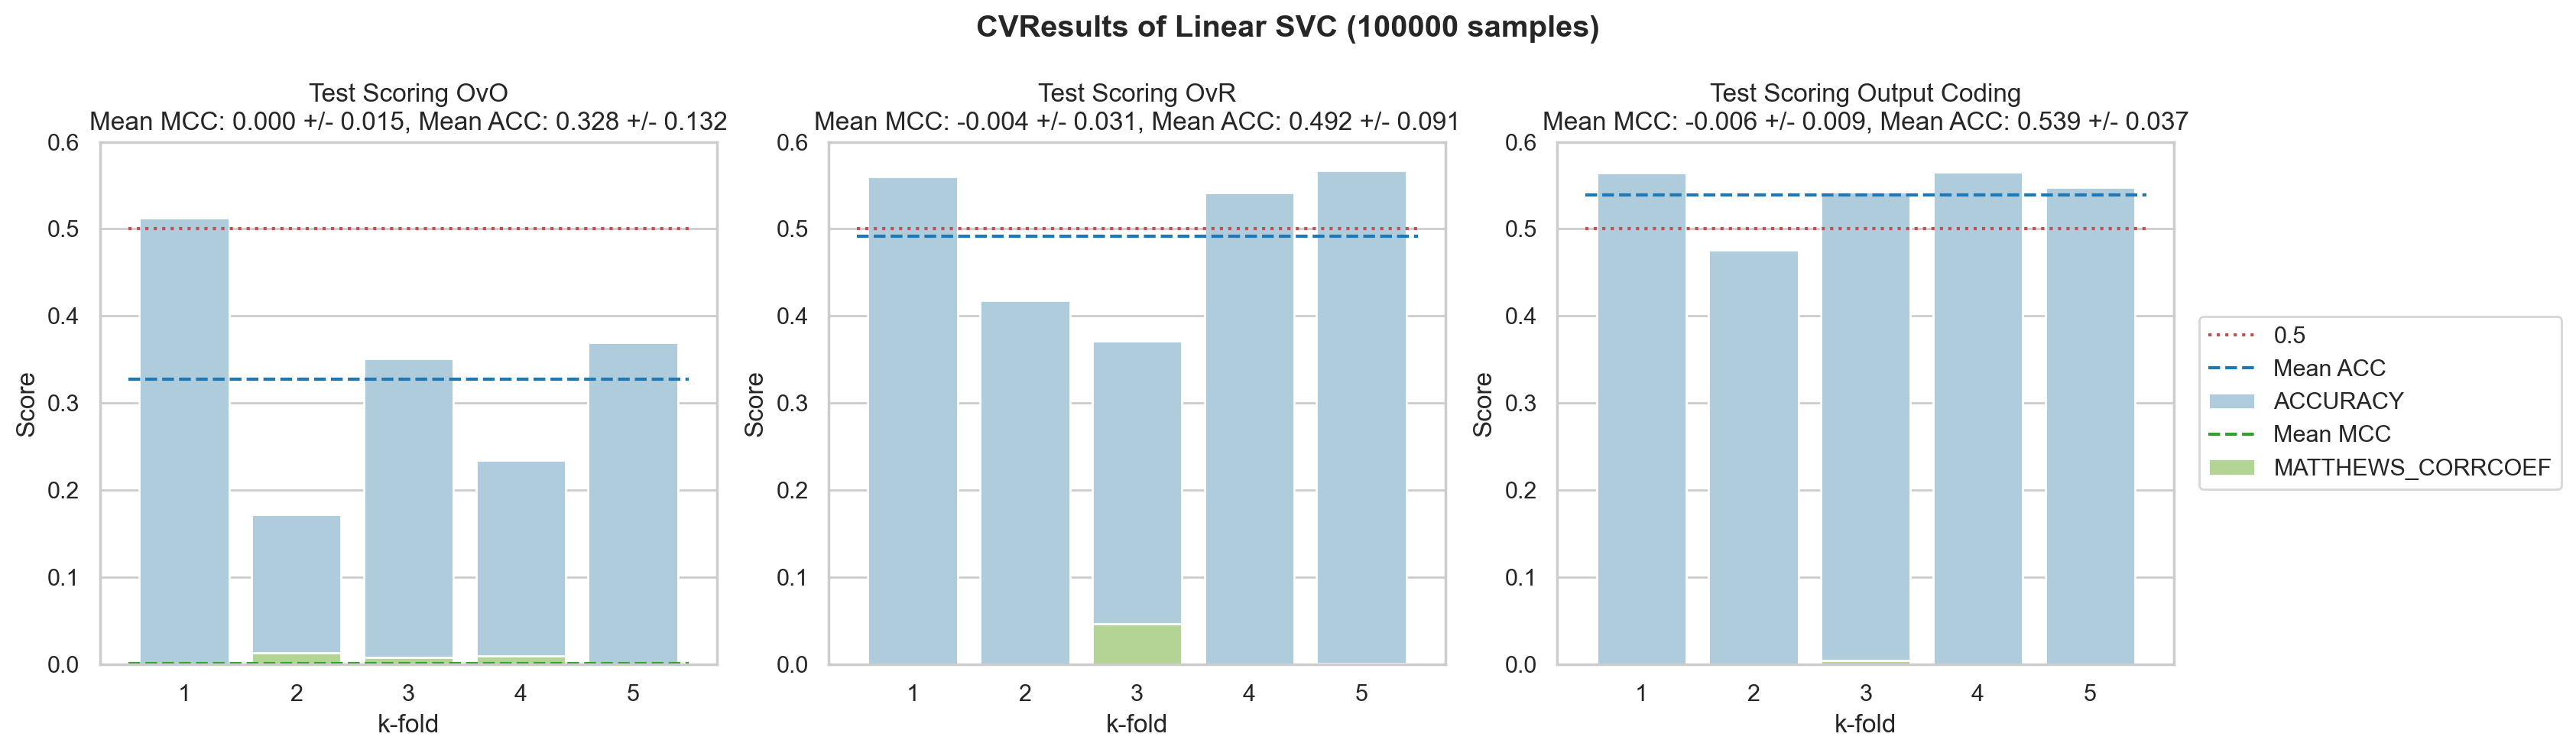

In [106]:
# compare linear svc models using meta-strategy OvO and OvR and output coding
compare_models_cv_acc_mcc([scores_lsvc_ovo, scores_lsvc_ovr, scores_lsvc_oc], ['OvO', 'OvR', 'Output Coding'], sample_size, (0.0, 0.6), (17, 5), f"CVResults of Linear SVC ({sample_size} samples)")
fig.savefig('../../data/figures/ovo_ovr_oc_lsvc.svg', dpi=300)

### XGBoost

In [27]:
%%time
# define output coding strategy
oc = OutputCodeClassifier(xgb, code_size=2, random_state=42)

# cross-validate model
scores_xgb_oc = cross_validate(oc, X_train, y_train['damage_grade'], cv=5, scoring=['accuracy', 'f1_macro', 'matthews_corrcoef'], n_jobs=-1)

# print results
print(f"Accuracy: {scores_xgb_oc['test_accuracy'].mean():.3f} +/- {scores_xgb_oc['test_accuracy'].std():.3f}")
print(f"F1-Score: {scores_xgb_oc['test_f1_macro'].mean():.3f} +/- {scores_xgb_oc['test_f1_macro'].std():.3f}")
print(f"MCC: {scores_xgb_oc['test_matthews_corrcoef'].mean():.3f} +/- {scores_xgb_oc['test_matthews_corrcoef'].std():.3f}")
print('-'*20)
print(f"Runtime: {scores_xgb_oc['fit_time'].mean():.3f} +/- {scores_xgb_oc['fit_time'].std():.3f}")
print('='*20)

Accuracy: 0.720 +/- 0.003
F1-Score: 0.651 +/- 0.004
MCC: 0.473 +/- 0.005
--------------------
Runtime: 332.607 +/- 0.504
CPU times: total: 31.2 ms
Wall time: 5min 40s


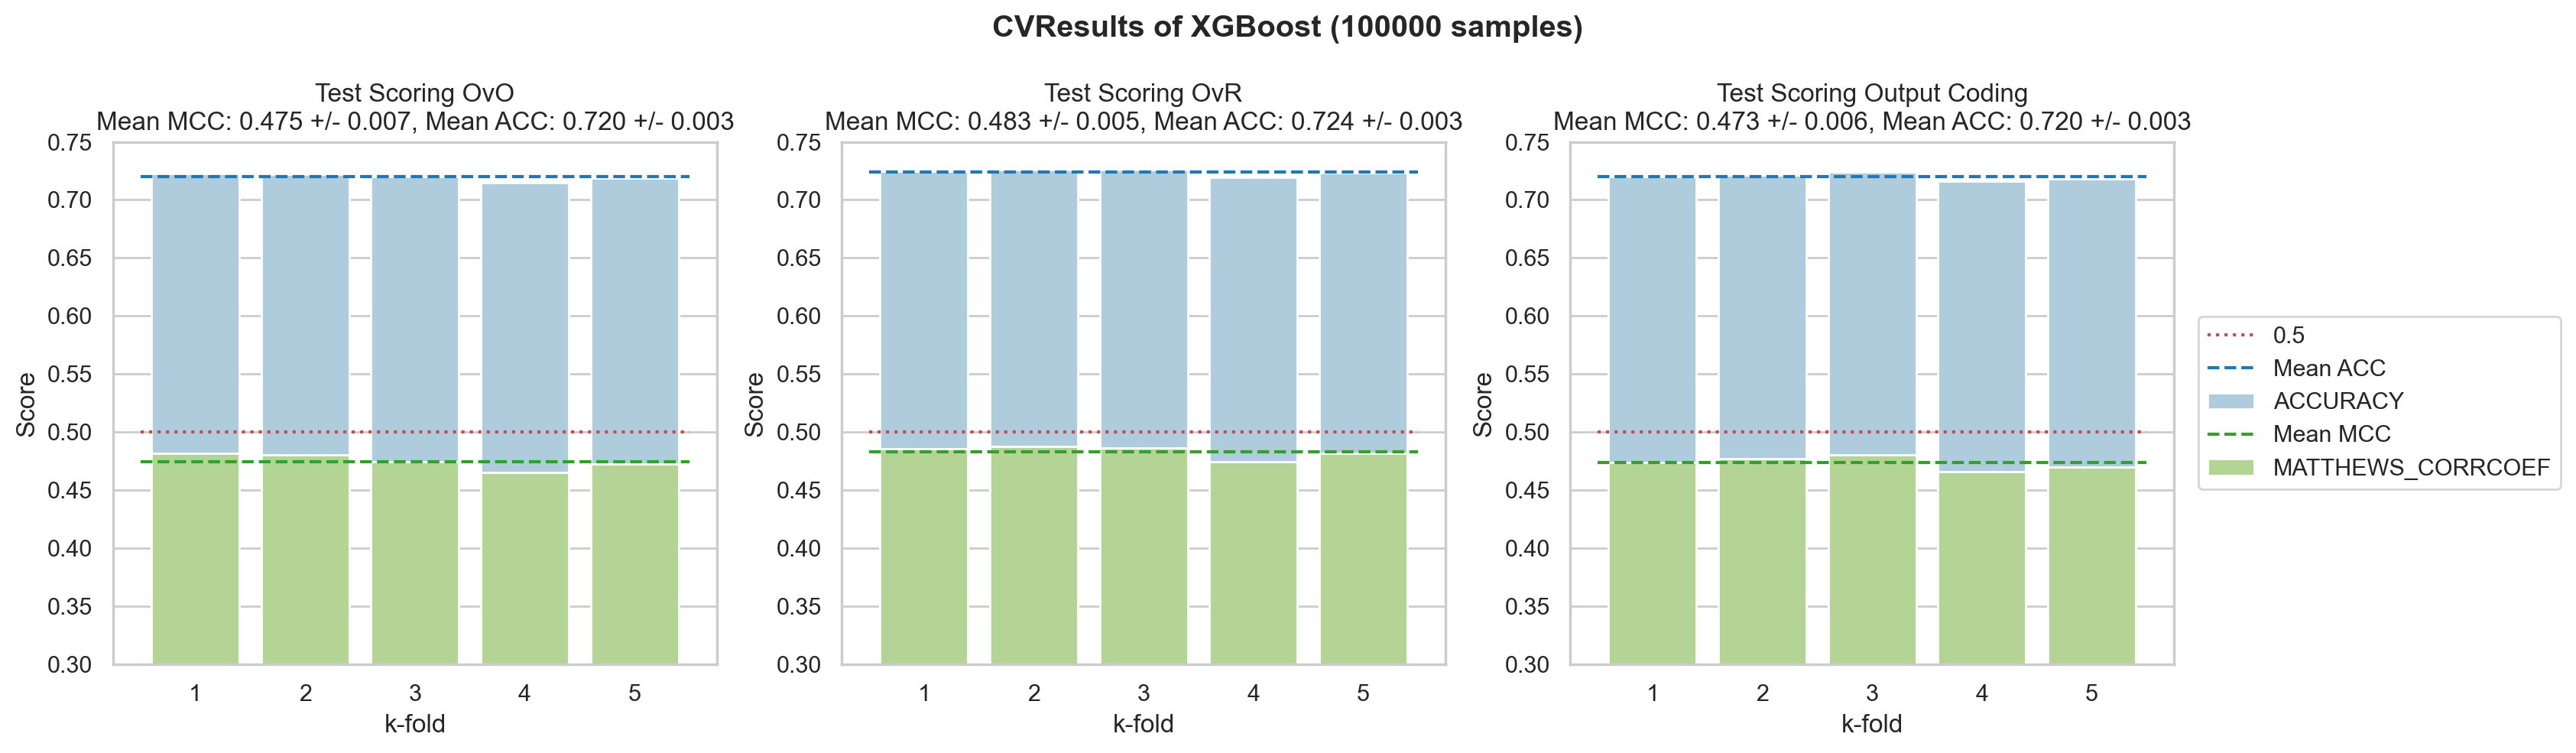

In [105]:
# compare xgb models using meta-strategy OvO and OvR and output coding
compare_models_cv_acc_mcc([scores_xgb_ovo, scores_xgb_ovr, scores_xgb_oc], ['OvO', 'OvR', 'Output Coding'], sample_size, (0.3, 0.75), (17, 5), f"CVResults of XGBoost ({sample_size} samples)")
fig.savefig('../../data/figures/ovo_ovr_oc_xgb.svg', dpi=300)

**Findings:**
The results are very similiar and in comparison to the base models XGBoost the ACC only changes in a postivie way by $+0.002$ from $ACC_{base} = 0.722$ to $ACC_{ovr} = 0.724$, using the ovr meta-strategy. Other than that there is no improvement seen tested o n a fairly big set of 100 000 samples using a solid 5-fold cross-validation.